### Agenda
- Coleta
  - Dados de Curitiba (A807), Z1
  - Dados de Manaus (A101), Z2
  - Dados de Belo Horizonte pampulha (A521), Z3
  - Dados de Brasilia (A001), Z4
  - Dados de Governador Valadares (A532), Z5
  - Dados de Rondonopolis (A907), Z6
  - Dados de Mossoró (A318), Z7
  - Dados do Rio de janeiro, forte de copacabana (A652), Z8
- Pré-processamento
- Visualização da série
- Estacionar a série
- Gráficos de correlação e autocorrelação (para saber os lags que usar)
- Implementação do modelo baseado nos dados
- Previsão

#### Literature:
    - https://medium.com/techbloghotmart/dicas-para-criar-um-modelo-de-previs%C3%A3o-de-s%C3%A9ries-temporais-d4bb2e32e148
    - https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
    - https://www.youtube.com/watch?v=2XGSIlgUBDI
    - https://www.youtube.com/watch?v=gLY-DWUNOgE&t=151s
    - https://www.youtube.com/watch?v=3UmyHed0iYE&t=33s
    - https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/
    - https://www.youtube.com/watch?v=v7rZpT8NCbk
    - https://medium.com/@ozdogar/time-series-forecasting-using-sarima-python-8db28f1d8cfc
    - https://www.youtube.com/watch?v=Al8m6K_stfA&t=452s (Explica os numeros do summary do modelo)
    - https://medium.com/@vinifarinha11rj55/tudo-que-voc%C3%AA-precisa-saber-sobre-s%C3%A9ries-temporais-afd3c1e56e42

#### Imports

In [1]:
%run UtilsNew.ipynb

In [2]:
from scipy import stats
import statsmodels.tsa.stattools as ts
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from time import time
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

set_plot_size(15, 3)

#### Carregando os dados
Como exemplo, foram usados os dados de 2024 até agora, da estação A001 (Brasilia)

In [3]:
raw_anual_df = pd.read_csv("data/minas_gerais_gv.csv", sep=";")

In [4]:
anual_df = pre_processing(raw_anual_df)

#### Qual horário devemos considerar?
Vamos verificar quais horários são revelantes. Primeiro,para o ano todo:

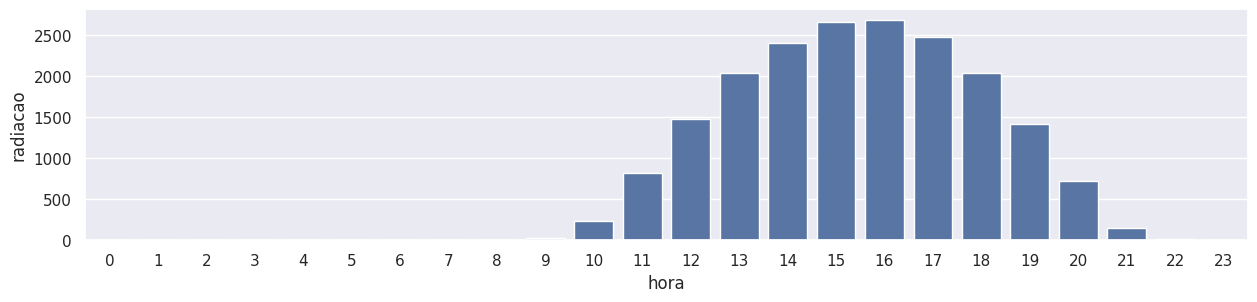

In [5]:
local_anual_df = anual_df[["data_hora", "radiacao", "temp_ins_c"]]

local_anual_df["hora"] = local_anual_df["data_hora"].dt.hour

local_anual_df = local_anual_df[["hora", "radiacao"]].groupby(['hora']).mean().reset_index()

plot = sns.barplot(local_anual_df, x="hora", y="radiacao")

Para ter certeza, iremos verificar para o ano todo, agrupando por mes:

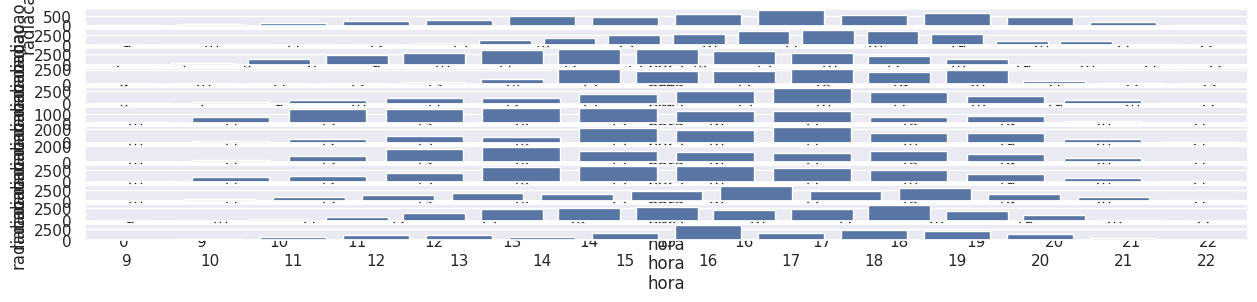

In [6]:
fig, axs = plt.subplots(nrows=12)
set_plot_size(10, 30)

for i in range(0, 12):
    rn_cut_anual_df = filter_between(anual_df, "data", "2024-" + str(i + 1) + "-01", "2024-" + str(i + 1) + "-01")
    rn_cut_anual_df = rn_cut_anual_df[["data_hora", "radiacao", "temp_ins_c"]]
    
    rn_cut_anual_df["hora"] = rn_cut_anual_df["data_hora"].dt.hour
    
    rn_cut_anual_df = rn_cut_anual_df[["hora", "radiacao"]].groupby(['hora']).mean().reset_index()
    
    sns.barplot(rn_cut_anual_df, x="hora", y="radiacao", ax=axs[i])

Como visto, a maioria dos meses possui valores relevantes de radiação a partir das 11h. Porém, existem meses que tem também valores a partir das 10h. Além disso, em sua maioria, os horários máximos com valores relevantes chegam as 21h e poucos as 22h. Portanto, utilizaremos valores das 11h as 21h.

In [7]:
anual_df["hora"] = anual_df["data_hora"].dt.hour
anual_df = filter_between(anual_df, "hora", 11, 21)

### A série é estacionária?

#### Análise visual
##### Toda a série
Aqui foi feito um resample para agrupar a série por dia, só para termos uma ideia do comportamento diário ao longo do ano. 

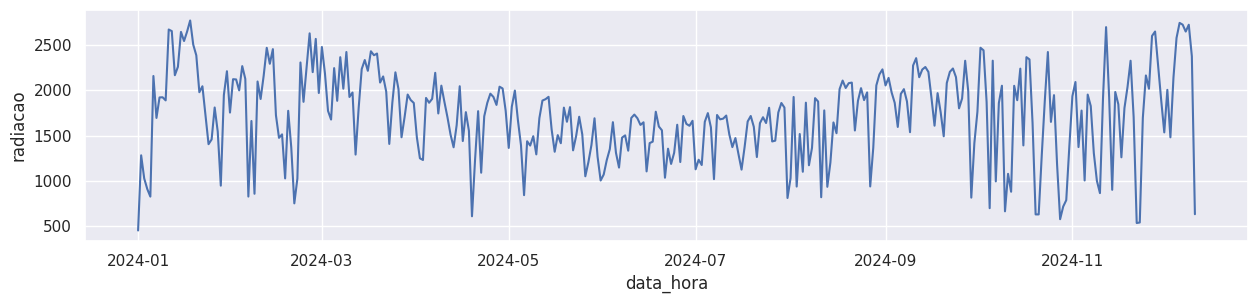

In [8]:
set_plot_size(15, 3)

anual_df_resampled = anual_df[["radiacao", "data_hora"]].set_index("data_hora").resample("D").mean()
plot = sns.lineplot(data=anual_df_resampled, x="data_hora", y="radiacao")

Obtendo um recorte onde uma possivel tendência mais evidente.

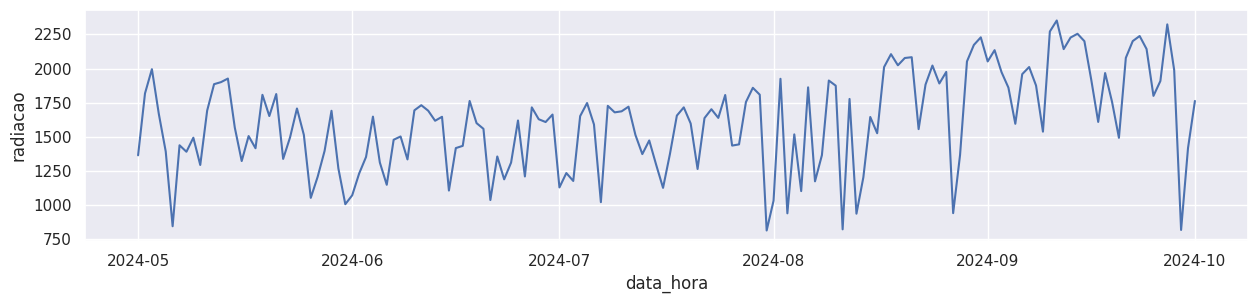

In [9]:
cut_anual_df = filter_between(anual_df, "data", "2024-05-01", "2024-10-01")

cut_anual_df_resampled = cut_anual_df[["radiacao", "data_hora"]].set_index("data_hora").resample("D").mean()
plot = sns.lineplot(data=cut_anual_df_resampled, x="data_hora", y="radiacao")

Visualizando um recorte semanal para tentar identificar uma possivel sazonalidade

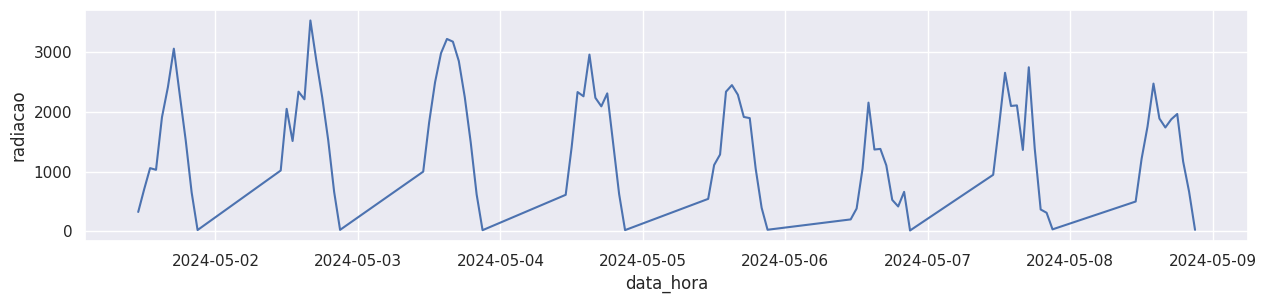

In [10]:
cut_anual_df = filter_between(anual_df, "data", "2024-05-01", "2024-05-08")
plot = sns.lineplot(data=cut_anual_df, x="data_hora", y="radiacao")

#### Teste de estacionariedade
##### AdFuler

In [11]:
def adfuller_test(df):
    result=ts.adfuller(df)
    labels = ['Teste estatístico ADF','p-valor','Num Lags','Numero de observações']
    for value, label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.")
    else:
        print("Fracas evidências contra a hipotese nula(Ho), a série temporal possui uma raíz unitária, indicando que é não estacionária.")


##### Teste com o recorte visualmente com tendência, sem resample

Teste estatístico ADF : -5.764232711275725
p-valor : 5.580706142686404e-07
Num Lags : 24
Numero de observações : 1669
Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.


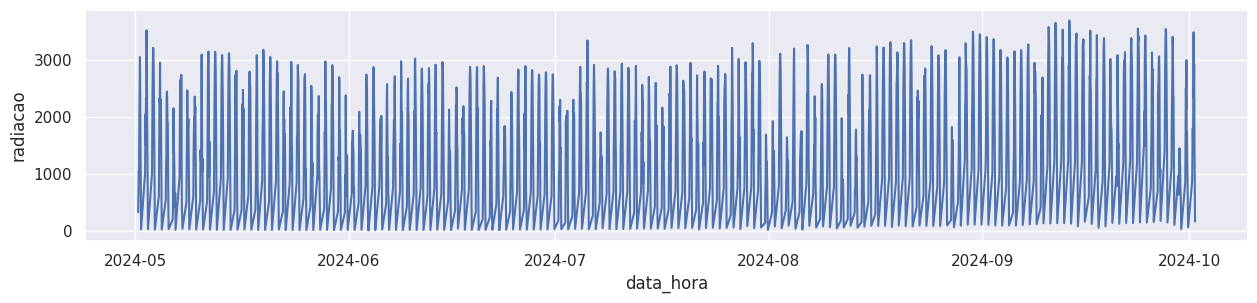

In [12]:
cut_anual_df = filter_between(anual_df, "data", "2024-05-01", "2024-10-01")[["radiacao", "data_hora"]]

plot = sns.lineplot(data=cut_anual_df.set_index("data_hora"), x="data_hora", y="radiacao")
adfuller_test(cut_anual_df["radiacao"])

##### Teste com o recorte visualmente com tendência, com resample

Teste estatístico ADF : -3.7415793287045824
p-valor : 0.0035648952271278467
Num Lags : 3
Numero de observações : 150
Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.


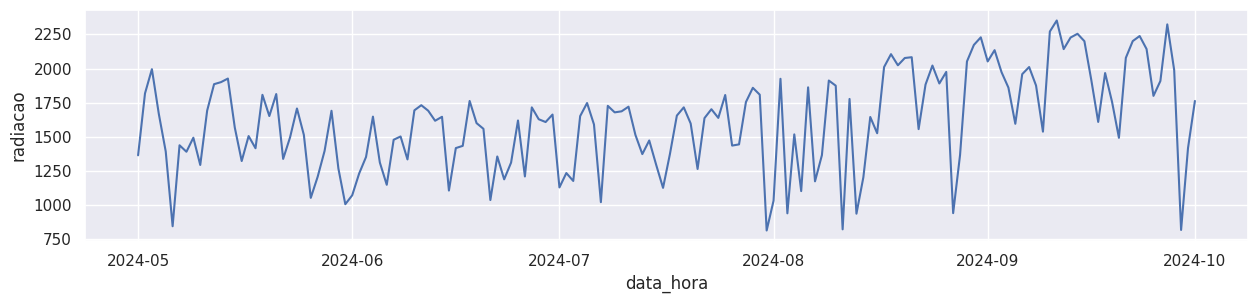

In [13]:
cut_anual_df_resampled = cut_anual_df.set_index("data_hora").resample("D").mean()

plot = sns.lineplot(data=cut_anual_df_resampled, x="data_hora", y="radiacao")
adfuller_test(cut_anual_df_resampled["radiacao"])

##### Teste com a serie toda, sem resample

Teste estatístico ADF : -8.147848555149961
p-valor : 9.877769173897664e-13
Num Lags : 30
Numero de observações : 3775
Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.


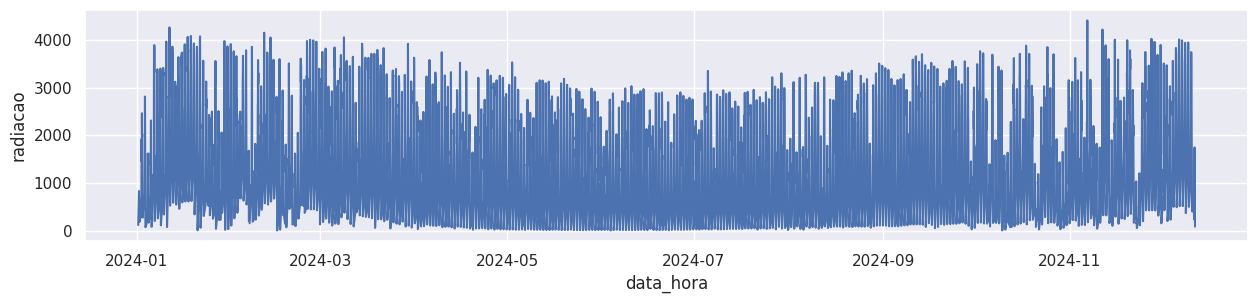

In [14]:
cut_anual_df = anual_df[["radiacao", "data_hora"]]

plot = sns.lineplot(data=cut_anual_df.set_index("data_hora"), x="data_hora", y="radiacao")
adfuller_test(cut_anual_df["radiacao"])

##### Teste com a serie toda, com resample

Teste estatístico ADF : -3.2856535673059875
p-valor : 0.015532067163718985
Num Lags : 10
Numero de observações : 335
Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.


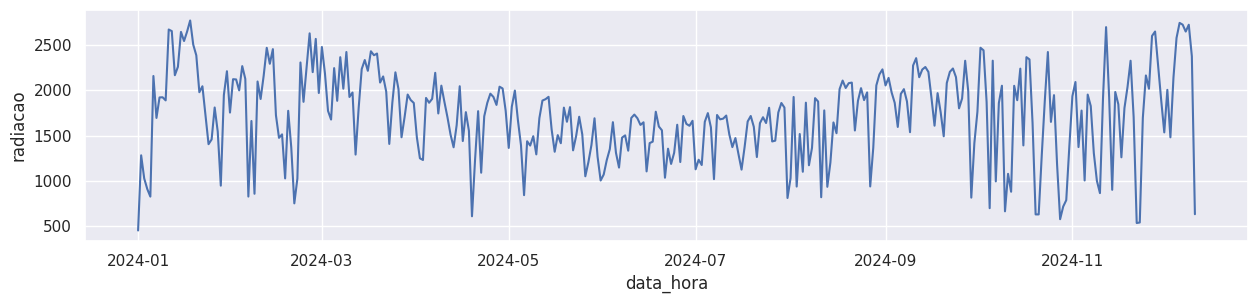

In [15]:
cut_anual_df = anual_df[["radiacao", "data_hora"]].set_index("data_hora").resample("D").mean()

plot = sns.lineplot(data=cut_anual_df, x="data_hora", y="radiacao")
adfuller_test(cut_anual_df["radiacao"])

A série original (horária) não apresenta evidências suficientes para ser classificada como não estacionária. Por tanto, não haverá a etapa de diferenciação. **[MESMO ASSIM APLICAR]** para remover tendência (horaria) e sazonalidade (14?)

### Diferenciação

In [16]:
def diferenciacao_aditivo(df_temp, col, periods=1):
    df_temp["shift"] = df_temp[col].shift(periods=periods, fill_value=0)
    df_temp["diff"] = df_temp[col] - df_temp["shift"]

    return df_temp

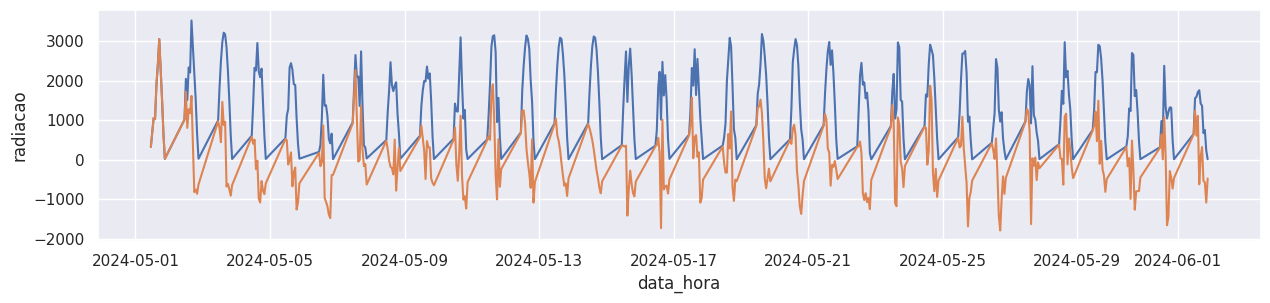

In [17]:
cut_anual_df = filter_between(anual_df, "data", "2024-05-01", "2024-06-01")[["data_hora", "radiacao"]]
# cut_anual_df = anual_df[["data_hora", "radiacao"]]
cut_anual_df["shift"] = cut_anual_df["radiacao"].shift(periods=12, fill_value=0)
cut_anual_df["diff"] = cut_anual_df["radiacao"] - cut_anual_df["shift"]


# cut_anual_df.head(50)
plot = sns.lineplot(data=cut_anual_df, x="data_hora", y="radiacao")
plot = sns.lineplot(data=cut_anual_df, x="data_hora", y="diff")

### ACF e PACF
**ACF:** Calcula a correlação dado um lag, levando em consideração os intervalos;</br>
**PACF:** Calcula a correlação enter dois pontos, descosiderando os intervalos.

Configurando os parametros sazonais e não sazonais (p, d, q, P, D, Q, m):

Parametros não sazonais (p, d, q):

    p: Verifique o gráfico PACF para identificar o número de defasagens de autorregressão. Picos significativos em defasagens específicas sugerem valores apropriados para p.
    d: Aplique diferenciação (tipicamente d=1d=1 para não estacionariedade) se a série mostrar uma tendência.
    q: Observe o gráfico ACF para determinar o componente da média móvel. Picos significativos em defasagens específicas sugerem valores apropriados para qq.

Parametros sazonais (P, D, Q, m):

    P: Verifique o PACF em múltiplos de 24 (para sazonalidade diária). Um pico no lag 24 sugere um componente autorregressivo.
    D: Use diferenciação sazonal (tipicamente D=1D=1) para remover padrões sazonais.
    Q: Verifique o ACF em múltiplos de 24 (ou outros períodos sazonais, se aplicável). Picos significativos em lags sazonais sugerem valores apropriados para QQ.
    Por exemplo, se houver padrões semanais, você também pode verificar o ACF e o PACF em múltiplos de 168 (ou seja, 7 dias × 24 horas).

**p:** AR model lags. Quantos lags eu quero usar no modelo</br> 
**d:** Differencing (quantas diferenciações eu apliquei)</br> 
**q:** MA lags. Aqui eu escolherei com base no ACF, em quantos picos com significancia surgirem (no grafico acima, dentro 40 surgiram 3)

Porém, se o ACF tem somente um pico, e não é exponencial, MA = 1. Mas, se o ACF é exponencial, tem varios picos, e o PACF tem somente um pico, dai o AR = 1

AFC = MA </br>
PAFC = AR 

#### Definindo
- AR ou p: responda a pergunta; o gafico PACF tem um decrescimento exponencial ou abrupto? Se é o primeiro, é 1. Se é o segundo, é 0 (?).

### Chat GPT
O **ACF (Autocorrelação)** e o **PACF (Autocorrelação Parcial)** são duas ferramentas importantes na análise de séries temporais, especialmente quando se utiliza modelos como AR (Auto-Regressivos) ou ARMA (Auto-Regressivos de Médias Móveis). Ambos ajudam a identificar a estrutura de dependência temporal dos dados, mas eles fazem isso de maneiras ligeiramente diferentes.

### ACF (Autocorrelação)
- **Definição**: O ACF mede a correlação entre uma série temporal e ela mesma, mas com diferentes defasagens (lags).
- **Como funciona**: Para cada defasagem \( k \), o ACF calcula a correlação entre os valores da série e os valores da mesma série \( k \) períodos atrás.
- **Objetivo**: O ACF ajuda a entender a persistência ou dependência de longo prazo em uma série temporal, ou seja, ele captura a dependência linear geral em várias defasagens.

### PACF (Autocorrelação Parcial)
- **Definição**: O PACF, por outro lado, mede a correlação entre uma série temporal e seus próprios valores defasados, **removendo** o efeito das defasagens anteriores. Ou seja, ele calcula a correlação entre a série e um valor defasado específico, controlando o efeito das correlações em defasagens anteriores.
- **Como funciona**: O PACF é usado para identificar a quantidade de dependência que existe em uma defasagem específica, removendo o efeito das autocorrelações que podem ser causadas pelas defasagens anteriores.
- **Objetivo**: O PACF é útil para identificar o número de termos autoregressivos (p) em um modelo AR, pois mostra claramente onde a correlação se torna insignificante, indicando o corte da dependência.

### Resumo das diferenças
- **ACF**: Mostra a correlação total de uma série temporal com suas defasagens, incluindo a influência de defasagens anteriores.
- **PACF**: Mostra a correlação de uma série temporal com uma defasagem específica, controlando as defasagens anteriores.

### Exemplo:
Se estivermos tentando ajustar um modelo ARMA à série temporal:
- O **ACF** pode ajudar a identificar a ordem do termo MA (média móvel).
- O **PACF** pode ajudar a identificar a ordem do termo AR (autoregressivo).

Portanto, ambos são complementares na escolha dos parâmetros de um modelo de séries temporais.


O modelo **SARIMA** (Seasonal AutoRegressive Integrated Moving Average) é uma extensão do modelo ARIMA, projetado para lidar com séries temporais que apresentam sazonalidade. Ele incorpora componentes sazonais além das partes autoregressiva (AR), de diferença (I) e de média móvel (MA) encontradas no ARIMA. 

O modelo SARIMA é especificado da seguinte forma:

**SARIMA(p, d, q)(P, D, Q)[s]**

Onde:
- **(p, d, q)** são os parâmetros para a parte não sazonal do modelo.
- **(P, D, Q)** são os parâmetros para a parte sazonal do modelo.
- **[s]** é o período de sazonalidade.

### Parâmetros do modelo SARIMA:

#### Parte não sazonal:
1. **p** (ordem autoregressiva - AR): 
   - Refere-se ao número de termos autoregressivos no modelo. Cada valor é uma combinação linear dos valores passados da série temporal.
   
2. **d** (ordem de diferenciação - I): 
   - Refere-se ao número de vezes que a série temporal precisa ser diferenciada para se tornar estacionária. Diferenciação é o processo de subtrair o valor de um ponto da série temporal do valor do ponto anterior.
   
3. **q** (ordem de média móvel - MA): 
   - Refere-se ao número de termos de média móvel no modelo. Cada valor é uma combinação linear dos erros passados (resíduos) da série temporal.

#### Parte sazonal:
4. **P** (ordem autoregressiva sazonal - SAR):
   - Refere-se ao número de termos autoregressivos sazonais, ou seja, o número de valores da série que são usados para prever a série em uma defasagem sazonal específica.

5. **D** (ordem de diferenciação sazonal - SI):
   - Refere-se ao número de vezes que a série precisa ser diferenciada sazonalmente para se tornar estacionária. A diferenciação sazonal é aplicada considerando a periodicidade sazonal da série (por exemplo, se a sazonalidade for anual, isso pode envolver subtrair o valor do ano passado).

6. **Q** (ordem de média móvel sazonal - SMA):
   - Refere-se ao número de termos de média móvel sazonais. Isso envolve os erros (resíduos) passados, mas com defasagens sazonais.

7. **s** (periodicidade sazonal): 
   - Refere-se à periodicidade ou à frequência da sazonalidade. Por exemplo, se a série tiver um padrão sazonal anual com dados mensais, então \( s = 12 \) (12 meses por ano). Para dados semanais com sazonalidade mensal, \( s = 4 \) (4 semanas por mês).

### Resumo das variáveis:
- **p, d, q**: parâmetros da parte não sazonal do modelo (autoregressivo, de diferenciação e de média móvel, respectivamente).
- **P, D, Q**: parâmetros da parte sazonal do modelo (autoregressivo sazonal, diferenciação sazonal e média móvel sazonal, respectivamente).
- **s**: o número de períodos que correspondem a uma temporada (sazonalidade).

### Exemplo:
Um modelo SARIMA(1, 1, 1)(1, 1, 1)[12] significa:
- **p = 1**: Um termo autoregressivo não sazonal.
- **d = 1**: A série precisa ser diferenciada uma vez para se tornar estacionária.
- **q = 1**: Um termo de média móvel não sazonal.
- **P = 1**: Um termo autoregressivo sazonal (sazonalidade de 12 períodos).
- **D = 1**: Uma diferenciação sazonal para lidar com a sazonalidade.
- **Q = 1**: Um termo de média móvel sazonal.
- **s = 12**: A série tem uma sazonalidade anual com dados mensais (12 períodos por ano).

O modelo SARIMA é muito útil para séries temporais com padrões sazonais claros, como vendas mensais de um produto, temperatura mensal, etc.


Os gráficos ACF (Autocorrelation Function) e PACF (Partial Autocorrelation Function) são ferramentas essenciais na análise de séries temporais. Eles ajudam a entender as dependências temporais em uma série e são particularmente úteis na identificação de modelos AR (AutoRegressivos), MA (Média Móvel) ou ARMA (AutoRegressivos de Média Móvel). Aqui está como interpretar esses gráficos:

### **Gráfico ACF (Autocorrelation Function)**

1. **Autocorrelação**: O ACF mostra a correlação entre uma série temporal e suas defasagens (lags). Ele mede a relação linear entre uma observação e as observações passadas.

2. **Interpretação**:
   - Se os pontos fora da faixa de confiança (geralmente representados por linhas azuis ou sombras) forem significativos, isso indica que há uma correlação forte entre a série e uma defasagem específica.
   - **Padrões típicos**:
     - **Decaimento lento**: Um ACF que decai lentamente sugere que a série pode ser integrada (ou seja, precisa ser diferenciada para se tornar estacionária). Isso é comum em séries com tendência, como no caso de um modelo ARIMA.
     - **Picos abruptos**: Se houver picos significativos em defasagens específicas, isso pode indicar a presença de um modelo MA (média móvel), onde as dependências são limitadas a algumas defasagens.

3. **Modelo MA (Média Móvel)**:
   - Se o gráfico ACF mostrar autocorrelações significativas até um certo ponto e depois cair abruptamente para zero, é um sinal de que o modelo pode ser MA (pode ser um MA(1), MA(2), etc.).
   
4. **Série estacionária**: Se o ACF não mostrar decaimento, pode indicar que a série é estacionária.

### **Gráfico PACF (Partial Autocorrelation Function)**

1. **Autocorrelação Parcial**: O PACF mostra a correlação entre uma observação e suas defasagens, **removendo o efeito das defasagens intermediárias**. Ou seja, ele mede a correlação direta entre uma observação e uma defasagem específica, sem o efeito das outras defasagens.

2. **Interpretação**:
   - **Padrões típicos**:
     - **Modelo AR (AutoRegressivo)**: O PACF é útil para identificar ordens de modelos AR. Se o PACF tiver um corte abrupto após um número específico de defasagens (ou seja, as autocorrelações parciais se tornam insignificantes após um número fixo de lags), isso sugere um modelo AR de ordem correspondente.
     - **Modelo AR(p)**: Se o PACF cair para zero após a primeira defasagem, isso sugere um modelo AR(1), e assim por diante.

3. **Modelo AR (AutoRegressivo)**:
   - Se o PACF mostrar um corte abrupto após a defasagem \( p \), isso indica que a série pode ser ajustada a um modelo AR(p), onde \( p \) é o número de defasagens significativas.

### **Como usar ACF e PACF para identificar o modelo ARIMA**:

1. **Modelo ARIMA**:
   - **Modelo AR (p)**: Olhe para o PACF. Se ele cair abruptamente após uma defasagem, isso sugere um modelo AR de ordem \( p \).
   - **Modelo MA (q)**: Olhe para o ACF. Se ele cair abruptamente após uma defasagem, isso sugere um modelo MA de ordem \( q \).
   - **Modelo ARMA(p, q)**: Se o gráfico de ACF tiver um decaimento gradual e o PACF cortar abruptamente após uma ordem, é possível que a série seja modelada por um ARMA(p, q).

### Resumo:

- **ACF**: Indica a correlação total entre a série e suas defasagens.
  - **Decaimento lento**: Sugestão de tendência, série não estacionária.
  - **Picos significativos**: Sugere um modelo MA.
  
- **PACF**: Indica a correlação direta entre a série e suas defasagens, removendo o efeito de outras defasagens.
  - **Corte abrupto**: Sugestão de um modelo AR.

Esses gráficos ajudam a entender melhor a estrutura temporal da série e a escolher o modelo adequado para modelá-la, especialmente ao aplicar modelos ARIMA.


Interpretar os gráficos **ACF (Auto-Correlation Function)** e **PACF (Partial Auto-Correlation Function)** é uma parte crucial do processo de identificação do modelo **SARIMA** (Seasonal Autoregressive Integrated Moving Average), que é uma extensão do modelo ARIMA que inclui componentes sazonais.

Aqui está uma explicação sobre como interpretar esses gráficos no contexto de SARIMA:

### **1. ACF (Auto-Correlation Function)**

O gráfico da ACF mostra a correlação das observações com seus próprios lags (defasagens). Em termos de SARIMA, ele ajuda a identificar o componente **MA (Moving Average)** e também fornece insights sobre os componentes sazonais.

- **Padrões de ACF em SARIMA:**
  - **Se o gráfico da ACF mostrar uma correlação significativa até certo número de lags e depois cair abruptamente para zero**, isso sugere que há uma componente **MA** (média móvel) no modelo. O número de lags significativos ajuda a determinar o parâmetro **q** (ordem da média móvel).
  - **Padrões sazonais na ACF**: Para a sazonalidade, você procurará picos de correlação em intervalos múltiplos de um certo número de períodos, que é a periodicidade sazonal \( s \). Se a sazonalidade for de 12 meses, por exemplo, você pode observar picos a cada 12 lags.

**Exemplo**: Se houver um pico na ACF no lag 12 (para um modelo anual com dados mensais), isso pode indicar um componente sazonal de ordem 12, sugerindo que a periodicidade sazonal seja de 12.

### **2. PACF (Partial Auto-Correlation Function)**

O gráfico de PACF mostra a correlação das observações com seus próprios lags, mas com o efeito das defasagens intermediárias removido. Em outras palavras, ele mede a relação direta entre as observações e o lag, sem a interferência das correlações de lags anteriores.

- **Padrões de PACF em SARIMA:**
  - **Se o gráfico de PACF mostrar um corte abrupto após um certo número de lags** (onde as correlações se tornam insignificantes), isso sugere que há uma componente **AR (Auto-Regressiva)** no modelo. O número de lags significativos ajuda a identificar o parâmetro **p** (ordem autoregressiva).
  - **Padrões sazonais na PACF**: Assim como na ACF, você também deve procurar por picos sazonais. A PACF sazonais normalmente terá picos em intervalos múltiplos de \( s \), similar ao padrão da ACF.

### **Interpretando os Gráficos para Identificar o Modelo SARIMA**

#### Componentes sazonais:
- **Sazonalidade não detectada:** Se a ACF e a PACF não mostrarem padrões sazonais (por exemplo, picos em múltiplos de \( s \)), então a componente sazonal do modelo SARIMA pode não ser necessária.
- **Sazonalidade identificada:** Se você observar picos significativos na ACF ou PACF em múltiplos de \( s \), isso sugere que você precisa de um termo sazonal no modelo. Para SARIMA, você terá três parâmetros sazonais:
  - **P**: ordem autoregressiva sazonal
  - **D**: número de diferenciações sazonais
  - **Q**: ordem da média móvel sazonal
  - **s**: a periodicidade sazonal (por exemplo, 12 para dados mensais com sazonalidade anual)

#### Passos para interpretar os gráficos:

1. **ACF**:
   - Se o gráfico mostra uma decaída exponencial (ou mais suave), isso indica um componente **AR** (autoregressivo).
   - Se o gráfico mostra uma rápida queda após um número fixo de lags, isso sugere um componente **MA** (média móvel).
   - Padrões sazonais podem aparecer como picos em lags múltiplos de \( s \).

2. **PACF**:
   - Se o gráfico apresenta um corte abrupto após um número fixo de lags, isso sugere um componente **AR**.
   - Padrões sazonais podem aparecer de forma similar, com picos em lags múltiplos de \( s \).

### **Exemplo Prático:**

Vamos supor que você está trabalhando com dados mensais e suspeita que há sazonalidade anual (12 meses). Ao analisar a ACF e PACF:

- **ACF**: Pode mostrar uma decaída mais suave (sugerindo um componente **MA**) e picos significativos a cada 12 lags (sazonalidade anual).
- **PACF**: Pode mostrar uma queda abrupta após o 1º ou 2º lag (indicando um componente **AR**) e também picos sazonais a cada 12 lags.

Com isso, você pode começar a ajustar um modelo SARIMA como, por exemplo, **SARIMA(1, 1, 1)(1, 1, 1)[12]** (onde \( P = 1 \), \( D = 1 \), \( Q = 1 \), e a periodicidade sazonal \( s = 12 \)).

### Conclusão:

A interpretação da ACF e PACF para um modelo SARIMA é uma tarefa fundamental para identificar os parâmetros corretos. Esses gráficos ajudam a entender a estrutura autoregressiva e de média móvel dos dados, tanto nos componentes não sazonais quanto sazonais. Com base nessa análise, você pode configurar o modelo de forma mais precisa, o que facilita a previsão e modelagem de séries temporais sazonais.

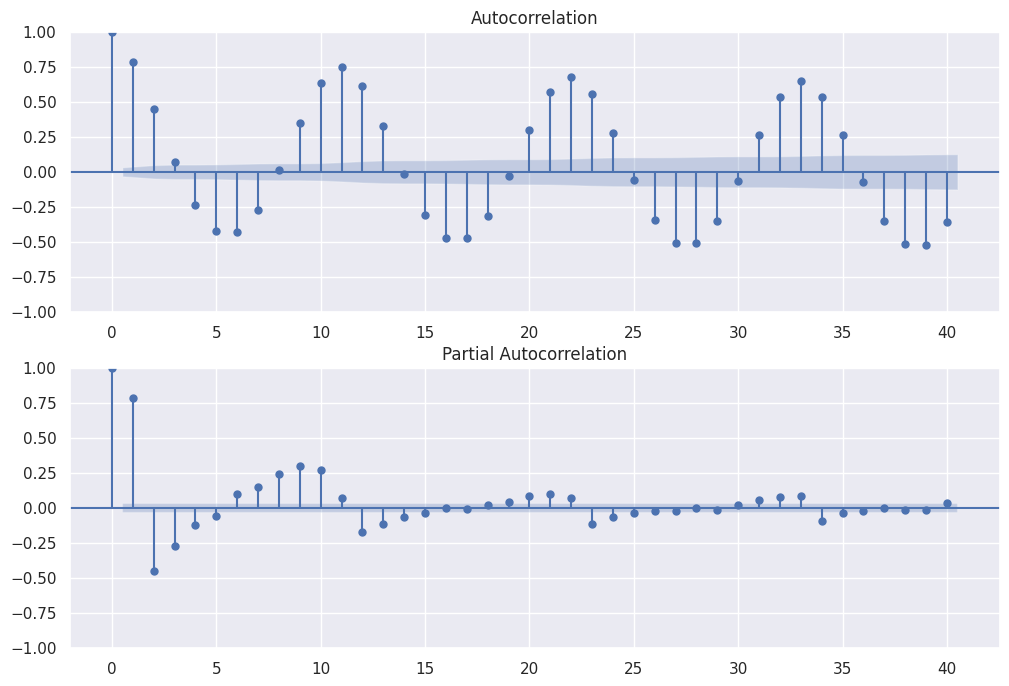

In [18]:
# df_to_model = filter_between(anual_df, "data", "2024-05-01", "2024-10-01")[["data_hora", "radiacao"]].set_index("data_hora")
df_to_model = anual_df[["data_hora", "radiacao"]].set_index("data_hora")

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_to_model,lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_to_model,lags=40, ax=ax2)

## Aplicando o modelo

In [19]:
def apply_sarima(df, order, seasonal_order):
    model = SARIMAX(df, order=order, seasonal_order=seasonal_order)

    model_fit = model.fit(trend="nc", disp=False) #Vericiar o que é o nc

    print(model_fit.summary())

    return model_fit

def predict(model_fit, df_to_model, col, start, end):
    df_to_model['forecast'] = model_fit.predict(start=start,end=end,dynamic=True)
    df_to_model[[col,'forecast']].iloc[start-10:end].plot(figsize=(12,8))    

def get_residual_with_metrics(df):
    df_residuos = df[~df["forecast"].isna()]
    df_residuos["diff"] = df_residuos["radiacao"] - df_residuos["forecast"]
    df_residuos["diff"].plot(figsize=(12,8), legend="Diff")

    mse = mean_squared_error(df_residuos["radiacao"], df_residuos["forecast"])
    mae = mean_absolute_error(df_residuos["radiacao"], df_residuos["forecast"])
    r2 = r2_score(df_residuos["radiacao"], df_residuos["forecast"])
    
    print("MSE: ", mse)
    print("RMSE:", sqrt(mse))
    print("MAE: ", mae)
    print("R2 score:", r2)

def apply_config_model(order, seasonal_order, whole_data=False):

    if whole_data:
        df_gp = anual_df[["data_hora", "radiacao"]].set_index("data_hora")
    else:
        df_gp = filter_between(anual_df, "data", "2024-05-01", "2024-10-01")[["data_hora", "radiacao"]].set_index("data_hora")
        
    model_fit = apply_sarima(df_gp, order, seasonal_order)
    predict(model_fit, df_gp, "radiacao", start=1588,end=1688)
    get_residual_with_metrics(df_gp)


def grid_search(df):
    p, d, q = 0, 0, 0
    _p, _d, _q, m = 1, 0, 3, 11
    
    order = (p, d, q)
    seasonal_order = (_p, _d, _q, m)

    model_fit = apply_sarima(df_to_model, order, seasonal_order)


### [DEPRECATE]1º Grupo: Maio até Outubro

### Usando 1a config

In [20]:
# order = (1, 0, 0)
# seasonal_order = (1, 0, 1, 11)

# apply_config_model(order, seasonal_order)

### Usando 2a config

In [21]:
# order = (0, 0, 0)
# seasonal_order = (1, 0, 1, 11)
# apply_config_model(order, seasonal_order)

### Usando 3a config

In [22]:
# order = (1, 0, 1)
# seasonal_order = (1, 0, 1, 11)
# apply_config_model(order, seasonal_order)

### Todo o dataset

### Usando 1a config

                                      SARIMAX Results                                       
Dep. Variable:                             radiacao   No. Observations:                 3806
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 11)   Log Likelihood              -28526.758
Date:                              Sun, 09 Feb 2025   AIC                          57061.516
Time:                                      18:31:40   BIC                          57086.493
Sample:                                           0   HQIC                         57070.392
                                             - 3806                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7443      0.010     74.871      0.000       0.725       0.764
ar.S.L11       1.00

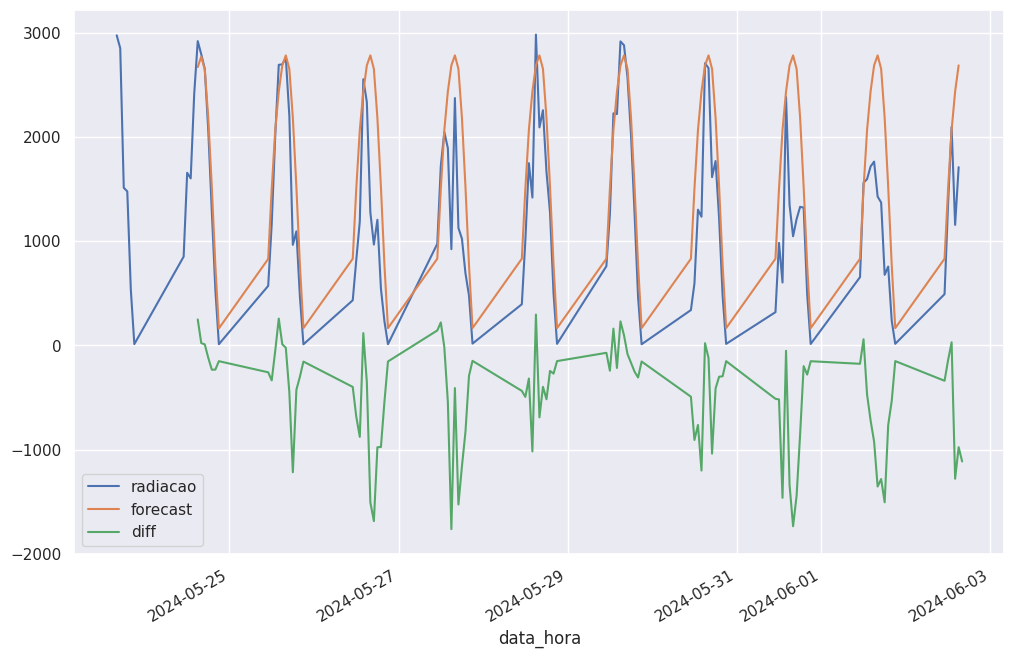

In [23]:
order = (1, 0, 0)
seasonal_order = (1, 0, 1, 11)
apply_config_model(order, seasonal_order, True)

### Usando 2a config

                                 SARIMAX Results                                  
Dep. Variable:                   radiacao   No. Observations:                 3806
Model:             SARIMAX(1, 0, [1], 11)   Log Likelihood              -29940.828
Date:                    Sun, 09 Feb 2025   AIC                          59887.657
Time:                            18:31:47   BIC                          59906.390
Sample:                                 0   HQIC                         59894.314
                                   - 3806                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L11       0.9992      0.000   2486.603      0.000       0.998       1.000
ma.S.L11      -0.8729      0.007   -126.527      0.000      -0.886      -0.859
sigma2      3.943e+0

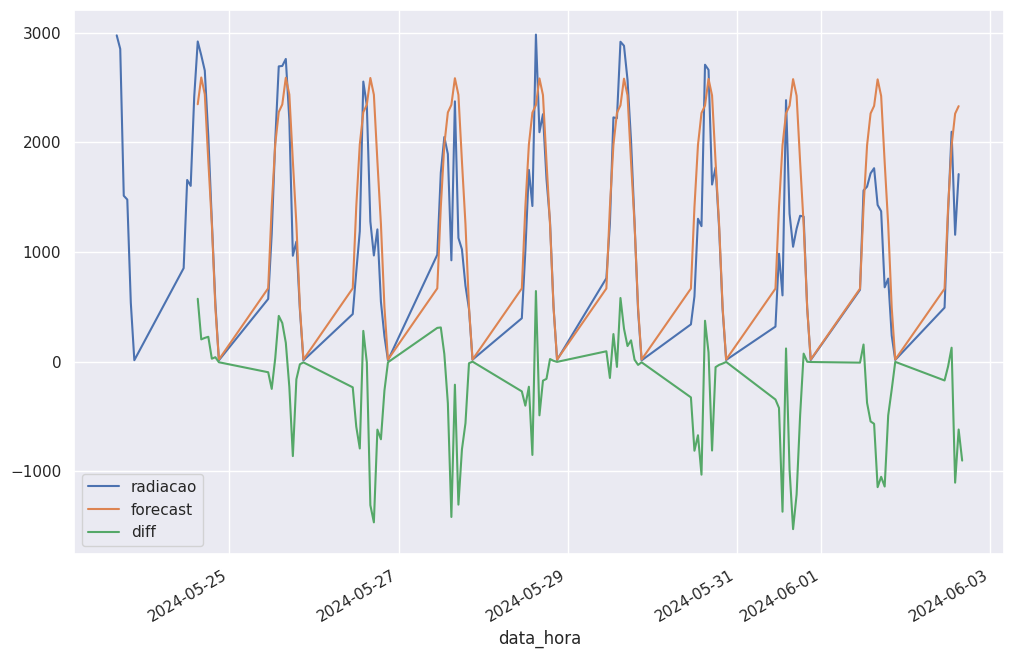

In [24]:
order = (0, 0, 0)
seasonal_order = (1, 0, 1, 11)
apply_config_model(order, seasonal_order, True)

### Usando 3a config

                                     SARIMAX Results                                      
Dep. Variable:                           radiacao   No. Observations:                 3806
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 11)   Log Likelihood              -28544.654
Date:                            Sun, 09 Feb 2025   AIC                          57099.308
Time:                                    18:32:11   BIC                          57130.530
Sample:                                         0   HQIC                         57110.403
                                           - 3806                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8127      0.013     63.719      0.000       0.788       0.838
ma.L1         -0.1858      0.020   

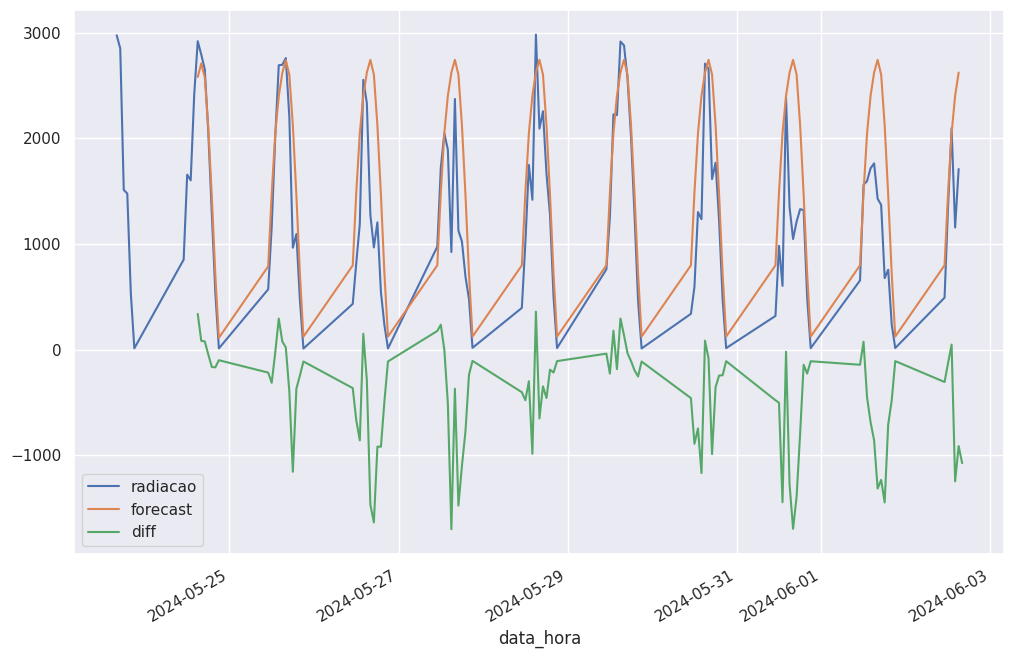

In [25]:
order = (1, 0, 1)
seasonal_order = (1, 0, 1, 11)
apply_config_model(order, seasonal_order, True)